# Policy Gradient in Reinforcement Learning

Many algorithms in today's reinforcement learning (such as, PPO, SAC, etc) includes the idea of policy gradient with actor critic and has great success in a lot of works. Furthermore this method can also operate stochastic environments and the continuous space in RL. For instance, you can use Gaussian distribution for even ```Box``` (continuos) action space, instead of using categorical distribution as follows.

This tutorial shows the idea of this method (algorithm) using simple program code.

> Following source code is inspired by rllib source code.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.

In [3]:
!pip install numpy gym keras tensorflow==2.4 matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |██████████████████████████▏     | 323.3 MB 99.6 MB/s eta 0:00:012  |██▌                             | 30.7 MB 7.3 MB/s eta 0:00:51     |██████████████                  | 171.7 MB 106.5 MB/s eta 0:00:03██████████████▉           | 257.5 MB 99.6 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 394.7 MB 124.1 MB/s eta 0:00:01

     |████████████████████████████████| 394.7 MB 3.3 kB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import gym
import numpy as np
import tensorflow as tf

In policy gradient, the action $a$ is picked up by the distribution $P$ which depends on policy $\pi$.<br>
To say more clearly, the distibution of action is $ P(a | \pi_\theta (s)) $ (which depends on the current state $s$), where $ \pi_\theta (s) $ is policy and $\theta$ is parameters for policy.

In this example, $\pi_\theta (s)$ is the following fcnet (fully-connected network) model, in which ```s_input``` is observation state (i.e, the returned state ```s``` in CarPole).

> Note : Here I assume logits output instead of probability output. When you use probability instead, please specify ```softmax``` as activation in final layer. (Also other functions in this example are assuming logits input.)

In [2]:
s_input = tf.keras.layers.Input(shape=(4, ))
hidden = tf.keras.layers.Dense(64,activation='relu')(s_input)
a_output = tf.keras.layers.Dense(2,activation='relu')(hidden)

policy_pi = tf.keras.Model([s_input], [a_output])

In each episode, we consider the following expectation $J(\theta)$.
$$ J(\theta)=E_{\pi\theta}[R] $$
where $R$ is obtained cumulative rewards $ R = \sum{\gamma r} $, and $\gamma$ is discount rate.

To get the optimimal $ \theta $ which maximizes $E$, we apply the gradient descent $ \theta_{t+1} \leftarrow \theta_t + \Delta \theta $<br>
where
$$ \Delta \theta = \alpha R \nabla_{\theta} \log{P(a|\pi_\theta(s))} $$
and $\alpha$ is learning rate.<br>
For instance, if the expected reward $R$ is positively large, the probability to take action $a$ in the state $s$ will be increased by modifying $\theta$. On contrary, if the expected reward $R$ is negative, $\theta$ will be changed to decrease the probability to take this action $a$.

> Note : As you can see below, the derivative of log probability is equivalent to the derivative devided by the magnitude of value. Thereby the derivative of log probability eliminates the dependency of the magnitude of initial values.
> $$ \nabla_{\theta} log(x(\theta)) = \frac{\nabla_{\theta}x}{x(\theta)} $$

As a result, the training script will become as follows.

> Note : The log probability equals to the negative value of cross-entropy error. Then I used ```tf.nn.sparse_softmax_cross_entropy_with_logits()``` to get log probability in the following code.

In [3]:
gamma = 0.99

# pick up action with above distribution policy_pi
def pick_sample(s):
    logits = policy_pi(tf.cast(np.array([s]), tf.float32))
    # return tf.Tensor([[a]], shape=(1, 1), dtype=int64)
    a_tensor = tf.random.categorical(logits, 1)
    # return tf.Tensor([a], shape=(1, 1), dtype=int64)
    a_tensor = tf.squeeze(a_tensor, axis=1)
    # return a
    return int(a_tensor.numpy()[0])

env = gym.make("CartPole-v0")
reward_records = []
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
for i in range(600):
    # Run episode till done
    done = False
    states_arr = []
    action_arr = []
    reward_arr = []
    s = env.reset()
    while not done:
        states_arr.append(s)
        a = pick_sample(s)
        s, r, done, _ = env.step(a)
        action_arr.append(a)
        reward_arr.append(r)

    # Change to cumulative rewards
    reward_arr_cum = np.zeros_like(reward_arr)
    reward_len = len(reward_arr)
    for j in reversed(range(reward_len)):
        reward_arr_cum[j] = reward_arr[j] + (reward_arr_cum[j+1]*gamma if j+1 < reward_len else 0)

    # Train parameters
    for s, a, r in zip(states_arr, action_arr, reward_arr_cum):
        with tf.GradientTape() as tape:
            logits = policy_pi(tf.convert_to_tensor(np.array([s])), training=True)
            # calculate log probability as loss (see above Note)
            log_prob = -tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits,
                labels=tf.convert_to_tensor(np.array([a])))
            loss = -log_prob * r
            grad = tape.gradient(
                loss,
                policy_pi.trainable_variables)
            opt.apply_gradients(zip(grad, policy_pi.trainable_variables))

    # Record total rewards in episode (max 200)
    print("Run episode{} with rewards {}".format(i, sum(reward_arr)), end="\r")
    reward_records.append(sum(reward_arr))

print("\nDone")
env.close()

Run episode599 with rewards 200.0
Done


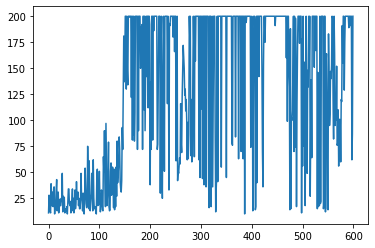

In [4]:
import matplotlib.pyplot as plt
plt.plot(reward_records)